# ASTR-589 HW2
## Numerically solve the balance equation to calculate the Stromgren radius.

We showed in the homework that the ionization fraction inside an HII region is given by the equation

$$
0 = \frac{2(1-x) R^2 \sigma_0 \nu_0^3 \pi^2 e^{-(1-x) n_H \sigma_0 r}}{n_H \alpha(T) r^2 c^2} \int_{u_0}^{\infty} \frac{1}{u} \frac{1}{e^u-1}~du - x^2
$$

We are given that $n_H = 10~\rm{cm}^{-3}$, $\sigma_0 = 6.3\times 10^{-18}~\rm{cm}^2$, and that $\alpha(T=10000\rm{K}) = 2.59\times10^{-13}~\rm{cm}^3~\rm{s}^{-1}$ inside the nebula.

In [9]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve, root, minimize, least_squares
import astropy.units as u
import scipy
from astropy.constants import c, h, k_B
import matplotlib.pyplot as plt

First, let us define the entire function as a product of three separate functions.

In [10]:
def unsolved(x, r, R, T, nH, s0, aT, l0):
    '''
    Function define the ionization fraction around a hot star in an HI region. Must be solved numerically.
    '''
    depend_val = depend(x, r, nH, s0)
    # BP Calculating all x-dependent terms.
    coeff_val = const(r, R, T, nH, s0, aT, l0)
    # BP Calculating all constant coefficient terms.
    integ_val = integ(l0, T)
    # BP Numerically integrating the integrand.
    
    return depend_val * coeff_val * integ_val - x**2

Next, lets define the first of the three functions that contains all of the x dependent terms.

In [65]:
def depend(x, r, nH, s0):
    '''
    Function to define all x-dependent terms in the ionization fraction equation.
    '''
    expo = np.exp(-(1-x)*(nH * s0 * r).cgs)
    # BP Calculating exponential part.
    
    return ((1-x) * expo).cgs

Next we define the constant terms.

In [66]:
def const(r, R, T, nH, s0, aT, l0):
    '''
    Function to calculate the constant coefficient terms in the ionization fraction equation.
    '''
    v0 = l0.to(u.Hz, equivalencies=u.spectral())
    # BP Calculating ionization frequency limit.
    numer = 2 * np.pi**2 * R**2 * s0 * v0**3
    # BP Calculating numerator.
    denom = c**2 * r**2 * nH * aT
    # BP Calculating denominator.
    
    return (numer / denom).cgs

We can then also calculate the value of the integral.

In [67]:
def integ(l0, T):
    '''
    Function to numerically integrate the integral in the ionization fraction equation.
    '''
    v0 = l0.to(u.Hz, equivalencies=u.spectral())
    # BP Converting the ionization wavelength into ionization frequency.
    u0 = h * v0 / (k_B * T)
    u0 = u0.cgs
    # BP Calculate the lower integration limit.
    
    def integrand(u):
    # BP Defining inner integrand to numerically solve.
        return 1 /( u * ( np.exp(u) - 1))
    
    I, _ = quad(integrand, u0, u0*100)
    # BP Numerically integrate from u0 to infinity.
    
    return I

In order to numerically solve the equation, we can also define the derivative to pass to the solver.

In [105]:
def deriv(x, r, R, T, nH, s0, aT, l0):
    '''
    The derivative of the unsolved function wrt x.
    '''
    depend_val = -np.exp(-(1-x)*(nH * s0 * r).cgs) + (1-x) * np.exp(-(1-x)*(nH * s0 * r).cgs) * (nH * s0 * r).cgs
    # BP Calculating all x-dependent terms.
    coeff_val = const(r, R, T, nH, s0, aT, l0)
    # BP Calculating all constant coefficient terms.
    integ_val = integ(l0, T)
    # BP Numerically integrating the integrand.
    
    return depend_val * coeff_val * integ_val - 2*x

Now we need to actually solve the defined equation, which we can do by using a root solving tool.

In [106]:
def ion_frac(r, R, T, nH=10/(u.cm**3), s0=6.3e-18*u.cm**2, aT=2.59e-13*u.cm**3/u.s, l0=912*u.AA):
    '''
    Function to calculate the ionization fraction at a given radius from a hot ionizing star. Can be looped over a grid of radii.
    '''
    func = lambda x: unsolved(x, r, R, T, nH, s0, aT, l0).cgs
    func_prime = lambda x: deriv(x, r, R, T, nH, s0, aT, l0).cgs
    # BP Defining function will all proper variables.
        
    zero = root(func, 1, jac = func_prime, method = 'hybr').x
    #zero = fsolve(func, [1], fprime = func_prime)
    # zero = least_squares(func, [1]).x
    # Solving for where the function equals 0.
    
    #p = poly(x, r, R, T, nH, s0, aT, l0)
    #zero = np.roots(p)
    
    return zero

We can now calculate the ionization fraction over the entire nebula.

## First Star
$T = 45000~\rm{K}$

$R = 11~R_\odot$

In [114]:
T1 = 45000*u.K
# BP Stellar temperature.
R1 = 11*u.R_sun
# BP Stellar radius.

rs = np.linspace(1, 40, 500)*u.pc
# BP Defining space to calculate ionization fraction in parsecs as Stromgren sphere is ~20 pc.
   
ionization1 = [ion_frac(r, R1, T1) for r in rs]

# Star 2
$T = 40000~\rm{K}$

$R = 20~R_\odot$

In [115]:
T2 = 40000*u.K
# BP Stellar temperature.
R2 = 20*u.R_sun
# BP Stellar radius.

rs = np.linspace(1, 40, 500)*u.pc
# BP Defining space to calculate ionization fraction in parsecs as Stromgren sphere is ~20 pc.
   
ionization2 = [ion_frac(r, R2, T2) for r in rs]

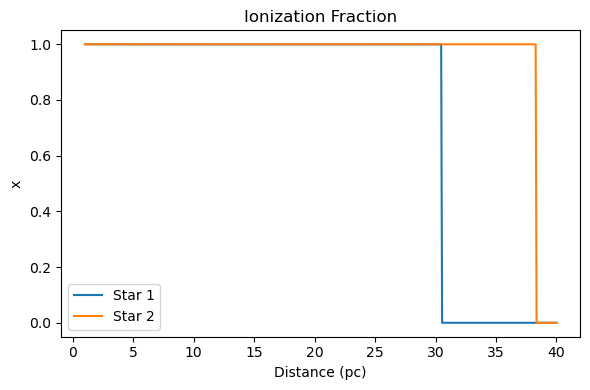

In [141]:
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(rs, ionization1, label = 'Star 1')
ax.plot(rs, ionization2, label = 'Star 2')
ax.set_xlabel('Distance (pc)')
ax.set_ylabel('x')
ax.set_title('Ionization Fraction')
ax.legend(loc = 'lower left')
plt.tight_layout()
plt.savefig('F:\Github\Coursework\ASTR-589\HW\HW2\HW2_3_a.png', dpi = 250)

From this we can calculate the Stromgren radius, which is essentially the middle of the sharp transition between fully ionized and fully unionized.

In [142]:
ionization1, ionization2 = np.array(ionization1), np.array(ionization2)
# BP Convert ionization into arrays.
rad1_ind = np.where(ionization1 > 0.5)[0][-1]
# BP Calculate last index where the ionization is above 0.5.
stromgren1 = rs[rad1_ind]
# BP Use this index to get the corresponding stromgren radius.

print('The Stromgren radius of the first star is {}'.format(stromgren1))

The Stromgren radius of the first star is 30.464929859719437 pc


In [143]:
rad2_ind = np.where(ionization2 > 0.5)[0][-1]
# BP Calculate last index where the ionization is above 0.5.
stromgren2 = rs[rad2_ind]
# BP Use this index to get the corresponding stromgren radius.

print('The Stromgren radius of the first star is {}'.format(stromgren2))

The Stromgren radius of the first star is 38.280561122244485 pc


# Part b
## Calculate the number of ionizing photons per second from each star.

The total ionizing flux for each star, after converting from the provided equation, is simply
$$
S_{uv} = 4\pi^2 R^2 \left(\frac{k_BT}{h}\right)^3 \int_{v_0}^{\infty} \frac{u^2}{e^u-1}~du
$$

In [65]:
l0 = 912*u.AA
# BP Setting lower integration limit.

In [66]:
T1 = 45000*u.K
R1 = 11*u.R_sun
# BP Defining star 1 properties.

S_uv1 = 8 * np.pi**2 * R1**2 / c**2 * (k_B * T1 / h)**3 * integ(l0, T1)
# BP Calculating numer of ionizing photons from star 1.

print(S_uv1.cgs)

2.744261869852677e+49 1 / s


/tmp/ipykernel_70148/852860727.py:13: RuntimeWarning: overflow encountered in exp
  return u**2 / (np.exp(u) - 1)


In [67]:
T2 = 40000*u.K
R2 = 20*u.R_sun
# BP Defining star 2 properties.

S_uv2 = 8 * np.pi**2 * R2**2 / c**2 * (k_B * T2 / h)**3 * integ(l0, T2)
# BP Calculating number of ionizing photons from star 2.

print(S_uv2.cgs)

4.890534991868073e+49 1 / s


/tmp/ipykernel_70148/852860727.py:13: RuntimeWarning: overflow encountered in exp
  return u**2 / (np.exp(u) - 1)


# Part c
## Calculate the stromgren radius for each star.
The analytical stromgren radius is given simply by
$$
R_s = \left( \frac{3 S_{uv}}{4\pi\alpha(T)n_H^2} \right)^{1/3}
$$
Using the results from the previous section,

In [62]:
aT = 2.59e-13*u.cm**3/u.s
nH = 10/(u.cm**3)
# BP Define constants used for stromgren radius calculation.

In [63]:
Rs1 = (3 * S_uv1 / (4 * np.pi * aT * nH**2) )**(1/3)
# BP Calculating stromgren radius for the first star.

print('The Stromgren radius of the first star is {}'.format(Rs1.to(u.pc)))

The Stromgren radius of the first star is 20.49565714159451 pc


In [64]:
Rs2 = (3 * S_uv2 / (4 * np.pi * aT * nH**2) )**(1/3)
# BP Calculating stromgren radius for the second star.

print('The Stromgren radius of the second star is {}'.format(Rs2.to(u.pc)))

The Stromgren radius of the second star is 24.848801903405054 pc
